# User databrowser search queries

## Investigating user search queries (``GET``)
The ``freva-storage-API`` can be used to get insights on how users use the databrowser and how important/unimportant certain datasets are. The restAPI is designed to make a pre-selection of all the user search queries and do a more in-depth analysis yourself.

In this example, we are going to examine the most popular variables of the ``era5`` data project. Information like that can be useful to determine frequently used or at least required datasets. 

To retrieve this information we are going to use the ``get`` method for the ``api/storage/stats/databrowser`` endpoint of the API. This ``get``method streams a string that is a csv representation of the user query data. This approach was chosen because the csv format can be used to load the data into a dataframe using ``pandas`` or ``dask``. 

In [1]:
%matplotlib inline
from tempfile import NamedTemporaryFile
import requests
from typing import Any
import pandas as pd

Before we start we will have to create a user token, as the data is protected. To do so use the ``post`` method of the ``api/token`` endpoint:

```python
res = requests.post("http://www.my-freva-instance.example.org/api/storage/v2/token", data={"username": "you_admin_username", "password":"your_admin_password"})
token = res.json()["access-token"]
```

After retrieving the token we can use the ```get``` method to search for all queries that were interested in the `era5` experiment. First, define the URL of the freva-storage-API

In [2]:
url = "http://0.0.0.0:8080"
token = "my-token" # This is only for demo purposes

The logic of the get path is ```<URL>/api/storage/stats/<PROJECT_NAME>/databrowser```, where PROJECT_NAME the name of the freva project is where the data is stored. Here we use the name `example-project`. 

The ``get`` request would be something like the following:

```python
requests.get("http://www.my-freva-instance.example.org/api/storage/stats/example-project/databrowser", 
             params={"experiment": "era5"}, 
             headers={"access-token": token})
```



Depending on how the data was filtered this can yield a considerably large data stream. To avoid draining server and client resources we can define a helper
function that allows us to store the data in a temporary file and read the data once saved. In the helper function, we use pandas to create the dataframe. If
the data might get too big to fit into memory then you could also use ``dask.dataframe`` to load the data chunks. Fortunately, this example is small:

In [3]:
# Function to load CSV data into a Dask DataFrame
def load_csv_data(url: str, **kwargs: Any) -> pd.DataFrame:
    """ Function to load CSV data into a pandas DataFrame.

    If the data gets too big then we should used dask instead of pandas.

    Parameters
    ---------
    url: str
        The url that is passed to the get method.
    **kwargs:
        Additional arguments passed to the get method

    Returns
    -------
    pandas.DataFrame

    Raises
    ------
    HTTPError: If anything goes wrong.
    """
    # Send a GET request to the URL to retrieve the CSV content in chunks
    with requests.get(url, **kwargs, stream=True) as response:
        response.raise_for_status()  # Raise an error for non-200 responses
        with NamedTemporaryFile(suffix=".csv") as temp_file:
            with open(temp_file.name, "wb") as stream:
                for chunk in response.iter_content(chunk_size=8192):  # Adjust chunk size as needed
                    stream.write(chunk)
            df = pd.read_csv(temp_file.name, index_col=0) # Use dask.dataframe if this get too big
            # Convert the date key to actual pandas dates.
            df["date"] = pd.DatetimeIndex(df["date"])
            return df


In [4]:
df = load_csv_data(f"{url}/api/storage/stats/example-project/databrowser",  params={"experiment": "era5"}, headers={"access-token": token})
df

,num_results,flavour,uniq_key,server_status,date,project,product,institute,model,experiment,...,grid_label,cmor_table,driving_model,format,grid_id,level_type,rcm_name,rcm_version,dataset,time
id,,,,,,,,,,,,,,,,,,,,,
64f6d0f1a26d23571f699c95,67893,freva,file,200,2023-09-05 06:55:45.645,NaN,NaN,NaN,NaN,era5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64f6d0f786c6c9cabe0c02e5,60789,freva,file,200,2023-09-05 06:55:51.585,NaN,NaN,NaN,NaN,era5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64f6d1016ad862821bea3540,999,freva,file,200,2023-09-05 06:56:01.045,NaN,NaN,NaN,NaN,era5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64f6d10b86c6c9cabe0c02e6,999,freva,file,200,2023-09-05 06:56:11.025,NaN,NaN,NaN,NaN,era5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64f6e6b9b2e53c7379de7123,999,cmip6,file,200,2023-09-05 08:28:41.891,NaN,NaN,NaN,NaN,era5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65b3818563635a294d5a6b79,53392,freva,file,200,2024-01-26 09:55:17.892,reanalysis,NaN,NaN,NaN,era5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65b3818a63635a294d5a6b7a,35552,freva,file,200,2024-01-26 09:55:22.045,reanalysis,NaN,NaN,NaN,era5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65b38401d140283777721ba0,39299,freva,file,200,2024-01-26 10:05:53.120,reanalysis,NaN,NaN,NaN,era5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#Now let's check the variables
variables = df[["variable"]].dropna()
variables.head()

,variable
id,
64f6d1016ad862821bea3540,tas
64f6d10b86c6c9cabe0c02e6,tas
64f6e6b9b2e53c7379de7123,tas
64f6e733291e8b3ba7d8745d,tas
64f6e738a26d23571f699c97,tas


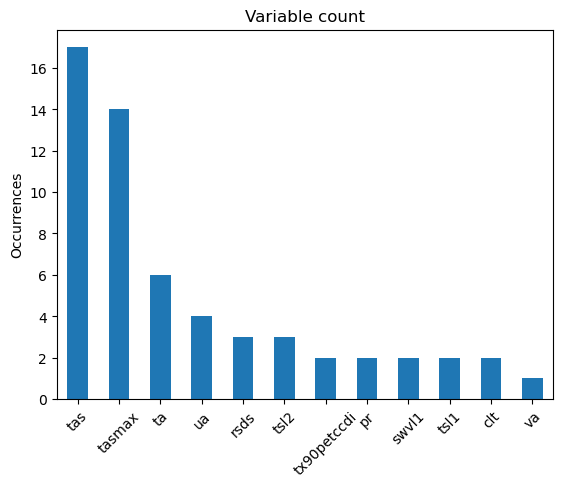

In [6]:
variables["variable"].value_counts().plot(kind="bar", title="Variable count", rot=45, xlabel="", ylabel='Occurrences');

## Adding data to the statistics (``POST``)
The ``post`` method can be used to store *new* data statistics. The data that is added must follow a certain schema, especially the metadata.
For more information on the schema please consult the ``api/storage/docs#`` endpoint of the API in your browser. Here we use the following example to store new data.
The `post` method is the only method where you don't need an authentication.

In [7]:
requests.post(f"{url}/api/storage/stats/example-project/databrowser",
              json={
                      "metadata": {
                        "num_results": 10,
                        "flavour": "freva",
                        "uniq_key": "file",
                        "server_status": 200,
                        "date": "string"
                      },
                      "query": {
                        "project": "cmip6"
                      }
                    }
)

<Response [201]>

The schema validation is strict. If we do not follow the schema, for example ``flavour=files`` or ``num_results`` a string the serve will reject the data:

In [8]:
requests.post(f"{url}/api/storage/stats/example-project/databrowser",
              json={
                      "metadata": {
                        "num_results": "10",
                        "flavour": "freva",
                        "uniq_key": "files",
                        "server_status": 200,
                        "date": "string"
                      },
                      "query": {
                        "project": "cmip6"
                      }
                    }
)

<Response [422]>

## Amending statistics data (PUT)

Existing data can be changed by using the ``put`` method. You can either change single keys like ``metadata.flavour`` or whole entries like ``query={"project": "cmip6"}``. You will have to figure out the data that needs to be amended. You can do that by using the ``get`` method or checking the JSON response of the ``post`` method. The key of the data that should be changed is handed over to the server as a path parameter:

In [9]:
requests.put(f"{url}/api/storage/stats/example-project/databrowser/65b38402d140283777721ba1",
             json={"query.product": "cmip"},
             headers={"access-token": token},   
)

<Response [200]>

Beware if you want to change complete entries, not only single keys, you have to make sure to follow the schema:

In [10]:
requests.put(f"{url}/api/storage/stats/example-project/databrowser/65b38402d140283777721ba1",
             json={"metadata": {"num_results": 10}},
             headers={"access-token": token},   
)

<Response [422]>

## Deleting entries (DELETE)
You can delete entries by their key. Like in the `put` method the key is given via the path parameter:

In [11]:
requests.delete(f"{url}/api/storage/stats/example-project/databrowser/65b38402d140283777721ba1",
             headers={"access-token": token},   
)

<Response [204]>